In [18]:
# Third-party library imports
import datasets
import numpy as np
from gensim import corpora, models
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import seaborn as sns
from scipy.spatial import procrustes
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Set IPython's ast_node_interactivity
InteractiveShell.ast_node_interactivity = "all"

In [19]:
def remove_extreme_files(text):
    count = len(text.split(" "))
    return count < 300 or count > 10000


def load_dfs():
    dataset = datasets.load_dataset("siavava/ai-tech-articles", split="train")
    df = dataset.to_pandas()
    df["text"] = df["text"].apply(lambda x: np.nan if remove_extreme_files(x) else x)
    return df.dropna()

In [20]:
df = load_dfs()

In [21]:
df.shape
df.head()

(16852, 5)

,id,year,title,url,text
0,0,2016,"""Human-Animal Chimeras Are Gestating on U.S. R...","""https://www.technologyreview.com/s/545106/hum...","""Featured Topics Newsletters Events Podcasts F..."
1,1,2013,"""Too Much Information | MIT Technology Review""","""https://www.technologyreview.com/s/522661/too...","""Featured Topics Newsletters Events Podcasts F..."
2,2,2017,"""Hacking the Biological Clock | MIT Technology...","""https://www.technologyreview.com/magazines/ha...","""Featured Topics Newsletters Events Podcasts F..."
3,3,2018,"""Six things to do with your data before you di...","""https://www.technologyreview.com/2018/10/23/2...","""Featured Topics Newsletters Events Podcasts F..."
4,4,2018,"""Your genome, on demand | MIT Technology Review""","""https://www.technologyreview.com/2018/10/23/1...","""Featured Topics Newsletters Events Podcasts F..."


In [22]:
def preprocess_text(text, stemmer):
    # Lowercasing and removing punctuation
    text = text.lower()

    # Splitting into words and removing stopwords
    stemmed_tokens = [
        stemmer.stem(word)
        for word in text.split()
        if word.isalpha() and word not in ENGLISH_STOP_WORDS
    ]

    return stemmed_tokens


def perform_lda(text_data, num_topics=10, passes=2):
    # Preprocess each document
    stemmer = PorterStemmer()
    texts = [preprocess_text(doc, stemmer) for doc in text_data]

    # Create a dictionary representation of the documents, and filter extremes from the dictionary
    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=15, no_above=0.5)  # Adjust parameters as needed

    # Bag-of-words representation of the documents
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Train the model
    lda_model = models.LdaModel(
        corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=passes,
        random_state=42,
    )

    return lda_model, corpus


lda_model, corpus = perform_lda(df["text"], num_topics=10, passes=2)

Let's quickly see the top 15 words for 10 topics.

In [23]:
top_words = lda_model.show_topics(10, 15)
for word in top_words:
    print(word[0], ":", word[1])

0 : 0.016*"model" + 0.008*"research" + 0.008*"train" + 0.007*"provid" + 0.007*"machin" + 0.005*"tool" + 0.005*"googl" + 0.005*"algorithm" + 0.004*"system" + 0.004*"perform" + 0.004*"human" + 0.004*"improv" + 0.004*"differ" + 0.004*"build" + 0.004*"requir"
1 : 0.010*"platform" + 0.009*"microsoft" + 0.009*"organ" + 0.008*"attack" + 0.007*"said" + 0.007*"market" + 0.006*"vb" + 0.006*"provid" + 0.006*"sponsor" + 0.006*"report" + 0.005*"cybersecur" + 0.005*"opportun" + 0.005*"million" + 0.005*"nov" + 0.005*"announc"
2 : 0.047*"game" + 0.018*"gamesbeat" + 0.009*"appl" + 0.008*"app" + 0.007*"brand" + 0.007*"million" + 0.006*"said" + 0.006*"get" + 0.006*"showcas" + 0.006*"award" + 0.006*"mobil" + 0.006*"brightest" + 0.006*"mind" + 0.006*"play" + 0.005*"player"
3 : 0.010*"window" + 0.009*"open" + 0.005*"research" + 0.005*"review" + 0.005*"mit" + 0.005*"page" + 0.004*"archiv" + 0.004*"govern" + 0.004*"newslett" + 0.003*"call" + 0.003*"human" + 0.003*"artifici" + 0.003*"law" + 0.003*"openai" + 0.

In [24]:
def get_topic_distributions(lda_model, corpus):
    """
    Returns the topic distribution for each document in the corpus. This is a vector of length 
    num_topics where each entry is the probability of that document belonging to that topic.
    """
    return [lda_model.get_document_topics(doc) for doc in lda_model[corpus]]

In [25]:
get_topic_distributions(lda_model, corpus)

[[(0, 0.05023635),
  (1, 0.050234664),
  (2, 0.050243795),
  (3, 0.050234035),
  (4, 0.050235953),
  (5, 0.050235517),
  (6, 0.05024222),
  (7, 0.05023135),
  (8, 0.050252233),
  (9, 0.5478539)],
 [(0, 0.05004415),
  (1, 0.050036572),
  (2, 0.05004551),
  (3, 0.050036207),
  (4, 0.05004343),
  (5, 0.050037745),
  (6, 0.050046287),
  (7, 0.050041813),
  (8, 0.050036628),
  (9, 0.5496317)],
 [(0, 0.0501174),
  (1, 0.05011326),
  (2, 0.050115414),
  (3, 0.05011943),
  (4, 0.050102938),
  (5, 0.05011413),
  (6, 0.05011268),
  (7, 0.05010999),
  (8, 0.050111998),
  (9, 0.54898274)],
 [(0, 0.050055094),
  (1, 0.050044682),
  (2, 0.050052773),
  (3, 0.05005343),
  (4, 0.05004797),
  (5, 0.0500499),
  (6, 0.050047297),
  (7, 0.050044876),
  (8, 0.050038666),
  (9, 0.5495653)],
 [(0, 0.05005272),
  (1, 0.050038997),
  (2, 0.05005038),
  (3, 0.05003733),
  (4, 0.05005102),
  (5, 0.050042767),
  (6, 0.05005186),
  (7, 0.050051887),
  (8, 0.05003787),
  (9, 0.54958516)],
 [(0, 0.05012282),
  (1, 0

In [26]:
def mean_of_arrays(array_list):
    return np.mean(np.vstack(array_list), axis=0)

def topic_dist_to_array(topic_dist, num_topics):
    distribution_array = np.zeros(num_topics)
    for topic, prob in topic_dist:
        distribution_array[topic] = prob  # Ensure numeric type
    return distribution_array

def aggregate_topic_distribution_by_year(df, topic_distributions, num_topics=10):
    df["topic_distribution_array"] = [topic_dist_to_array(topic_dist, num_topics) for topic_dist in topic_distributions]
    return df.groupby('year')['topic_distribution_array'].apply(
        lambda x: np.mean(np.vstack(x), axis=0))

yearly_topic_distributions = aggregate_topic_distribution_by_year(df, get_topic_distributions(lda_model, corpus), num_topics=10)

Now that we have the yearly topic distribution, let's perform procrutes analysis to compare the yearly topic distributions in two ways:
- Compare each year with the next (consecutive years) to see how topic distributions evolve from one year to the next.
- Compare every year with every other year to show the distance between all the years.

In [38]:
def compare_consecutive_years_with_procrustes(yearly_distributions):
    """
    Performs Procrustes analysis to compare yearly topic distributions.
    Each yearly distribution in the Series is treated as a 1D array.
    """
    results = []
    num_years = len(yearly_distributions)

    for i in range(num_years - 1):
        # Retrieve the topic distribution arrays for consecutive years
        dist_1 = yearly_distributions.iloc[i]
        dist_2 = yearly_distributions.iloc[i + 1]

        # Ensure the distributions are numpy arrays and add a row of zeros to make them 2D
        shape1 = np.vstack([dist_1, np.zeros(len(dist_1))])
        shape2 = np.vstack([dist_2, np.zeros(len(dist_2))])

        # Perform Procrustes analysis
        _, _, disparity = procrustes(shape1, shape2)
        results.append(disparity)

    return results


def compare_all_years_with_procrustes(yearly_distributions):
    """
    Compares the topic distributions for each pair of years using Procrustes analysis.
    Returns a matrix of disparities (distances) between each pair of years.
    """
    n_years = len(yearly_distributions)
    disparities = np.zeros((n_years, n_years))

    for i in range(n_years):
        for j in range(i + 1, n_years):
            dist_1 = yearly_distributions.iloc[i]
            dist_2 = yearly_distributions.iloc[j]

            # Convert 1D arrays to 2D
            shape1 = np.vstack([dist_1, np.zeros(len(dist_1))])
            shape2 = np.vstack([dist_2, np.zeros(len(dist_2))])

            _, _, disparity = procrustes(shape1, shape2)
            disparities[i, j] = disparity
            disparities[j, i] = disparity

    return disparities

In [39]:
# Run the two Procrustes analyses
consecutive_disparities = compare_consecutive_years_with_procrustes(yearly_topic_distributions)
all_disparities = compare_all_years_with_procrustes(yearly_topic_distributions)

In [40]:
for i in range(len(consecutive_disparities)):
    print("Disparity between years 20{:02} and 20{:02}: {disparity}".format(i, i + 1, disparity=consecutive_disparities[i]))

Disparity between years 2000 and 2001: 2.965932114356343e-31
Disparity between years 2001 and 2002: 6.848606882241011e-31
Disparity between years 2002 and 2003: 9.976317111925882e-32
Disparity between years 2003 and 2004: 8.580017902245136e-32
Disparity between years 2004 and 2005: 1.8488927466117464e-31
Disparity between years 2005 and 2006: 9.321500930834222e-32
Disparity between years 2006 and 2007: 2.1531896778249297e-31
Disparity between years 2007 and 2008: 1.852744606500521e-31
Disparity between years 2008 and 2009: 5.315566646508771e-32
Disparity between years 2009 and 2010: 1.305780502294546e-31
Disparity between years 2010 and 2011: 1.0631133293017542e-31
Disparity between years 2011 and 2012: 1.8797076257219422e-31
Disparity between years 2012 and 2013: 7.51112678311022e-32
Disparity between years 2013 and 2014: 3.0429693121318326e-31
Disparity between years 2014 and 2015: 3.185488128016488e-31
Disparity between years 2015 and 2016: 3.28178462523585e-31
Disparity between yea

In [41]:
all_disparities

array([[0.00000000e+00, 2.96593211e-31, 2.01067086e-31, 3.35111810e-32,
        3.47052576e-31, 5.46964104e-32, 1.10933565e-31, 5.39260384e-32,
        2.92741352e-32, 1.07466891e-31, 7.04890360e-32, 5.54667824e-32,
        3.89037849e-32, 6.97186640e-32, 1.66400347e-31, 6.93334780e-32,
        1.52918838e-31, 5.93186423e-32, 1.10163193e-31, 9.70668692e-32,
        4.88801020e-31, 8.95557424e-31, 1.83733717e-31, 3.43200716e-31],
       [2.96593211e-31, 0.00000000e+00, 6.84860688e-31, 7.01038500e-32,
        8.01186857e-32, 3.27408091e-31, 1.01689101e-31, 2.59230171e-31,
        1.21718772e-31, 1.79881857e-31, 4.31408308e-32, 1.24029888e-31,
        1.02844659e-31, 1.10933565e-31, 8.43557316e-32, 3.81334129e-32,
        4.17156426e-31, 5.28860363e-31, 8.55112895e-32, 2.67704262e-31,
        2.23793060e-31, 1.16326169e-31, 2.97363583e-31, 4.52208351e-31],
       [2.01067086e-31, 6.84860688e-31, 0.00000000e+00, 9.97631711e-32,
        2.16859712e-31, 5.77008611e-31, 1.12474309e-31, 1.1555

Let's now make a line chart presented to study the disparity in topic distributions between consecutive years, ranging from 2000 to 2023. Each data point in `consecutive_disparities` represents the Procrustes disparity between the topic distribution of one year and the following year, indicating the magnitude of change in thematic content.

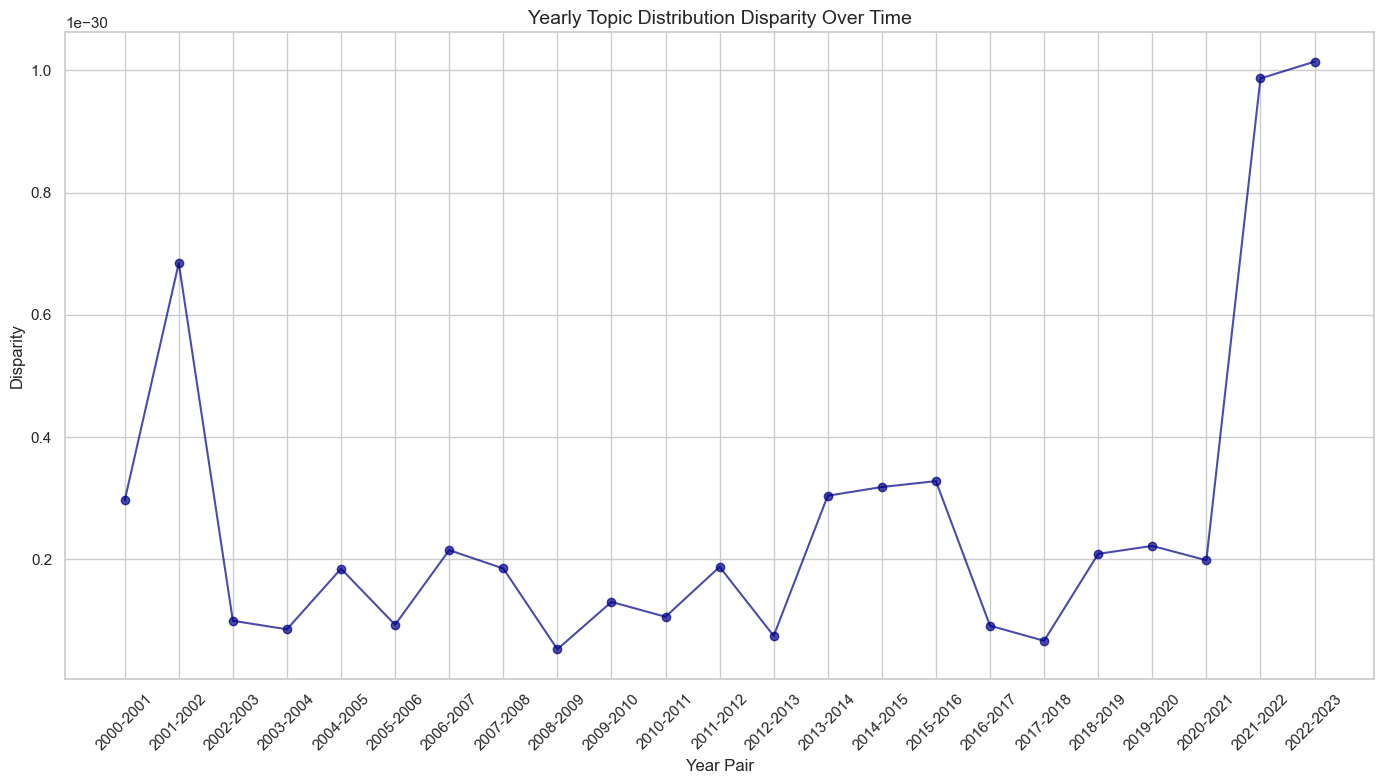

In [42]:
def plot_procrustes_distance_between_consecutive_years(consecutive_disparities, from_year, to_year):
    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 8))

    # Adjust the range to align with the number of disparities
    years = range(from_year, to_year)
    year_pairs = [f"{y}-{y+1}" for y in years]

    # Use a custom color and marker style
    plt.plot(year_pairs, consecutive_disparities, marker='o', color='darkblue', linestyle='-', alpha=0.7)

    # Add labels and title
    plt.xlabel("Year Pair", fontsize=12)
    plt.ylabel("Disparity", fontsize=12)
    plt.title("Yearly Topic Distribution Disparity Over Time", fontsize=14)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add a grid
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_procrustes_distance_between_consecutive_years(consecutive_disparities, 2000, 2023)

In the plot above, a lower disparity value suggests a higher similarity in topic distributions (the 10 topics for LDA) from one year to the next, while a higher value denotes a more pronounced change.

Analysis:
- In the early 2000s, there is a relatively minor flucations in disparity. 
- However, we observe noticable peaks and drops in the period between 2001-2002, 2013-2016, and 2018 onwards. 
- These peaks may correspond to significant shifts in the discourse, potentially due to technological advancements, societal changes, or major global events influencing the content of the dataset, such as presidential elections and the introduction of LLMs.

Let's now make another plot delineating the evolution of topic distribution disparity from 2000 to 2023, using 2022 as a reference year. The choice for using 2022 as a reference year was made as it is the year where LLMS were largly introduced. However, we could have also chosen other years.

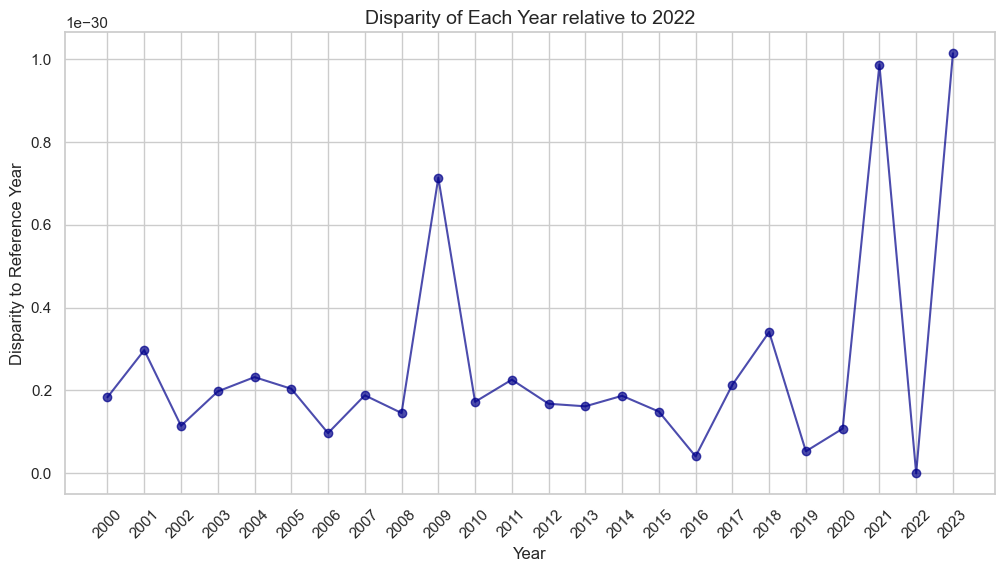

In [54]:
def plot_disparity_against_reference_year(disparities, reference_year_index, year_labels):
    reference_disparities = disparities[reference_year_index, :]
    
    plt.figure(figsize=(12, 6))
    plt.plot(year_labels, reference_disparities, marker='o', color='darkblue', linestyle='-', alpha=0.7)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Disparity to Reference Year", fontsize=12)
    plt.title(f"Disparity of Each Year relative to {year_labels[reference_year_index]}", fontsize=14)
    plt.xticks(year_labels, rotation=45)
    plt.show()

# Example usage - comparing each year to the first year
# We can choose any other year as the reference year
plot_disparity_against_reference_year(all_disparities, 22, yearly_topic_distributions.index)


Compared to 2022, there is a significant difference in the topics of 2009, 2021, and 2023. This indicates years where the discussion topics notably diverged from those typical of 2017. 

Let's make an explository bar charts for showcasing the topic distributions per year and try to understand the reason for the huge disparity between 2021, 2022, and 2023.

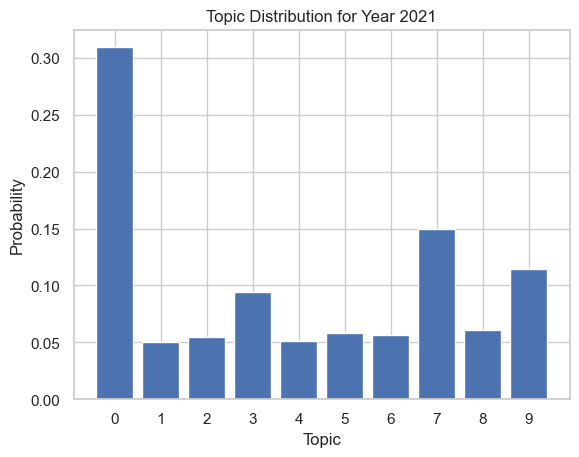

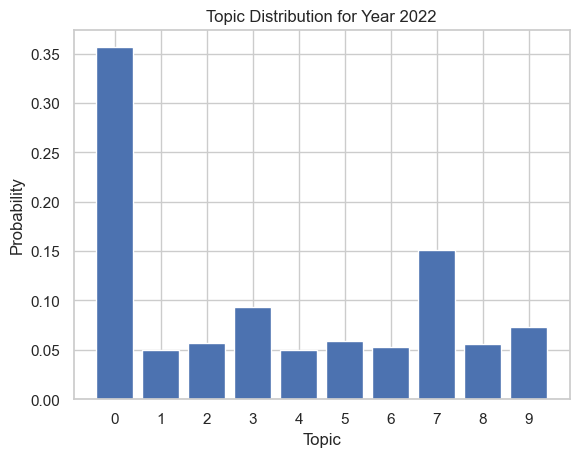

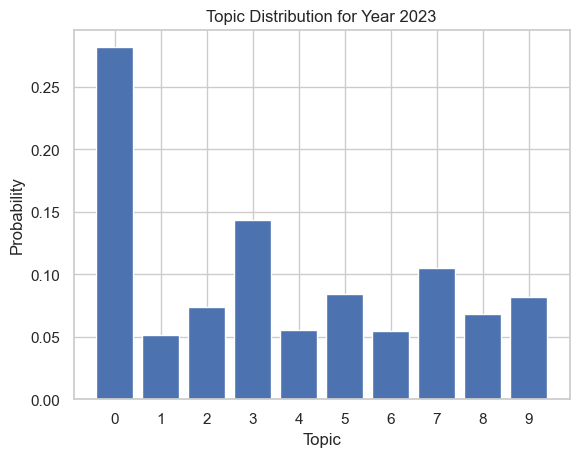

In [61]:
def plot_topic_distribution_for_year(yearly_distributions, year, num_topics):
    """
    Plots a bar chart of the topic distribution for a specific year.
    """
    distribution = yearly_distributions.loc[year]
    topics = range(num_topics)
    
    plt.bar(topics, distribution)
    plt.xlabel('Topic')
    plt.ylabel('Probability')
    plt.title(f'Topic Distribution for Year {year}')
    plt.xticks(topics)
    plt.show()

for year in range(2021, 2024):
    plot_topic_distribution_for_year(yearly_topic_distributions, year, 10)


Quick observations (comparing 2021 and 2023 with 2022):
- there is about 2x decrease for topic 9 from 2021 to 2022.
- there is a significant increase in topics 3 and 9 from 2022 to 2023.

Therefore, let's see the top 10 words for each topics 3 and 9 and try to understand the reason for the disparity.

In [66]:
def print_top_k_words(lda_model, id, k):
    print(f"Topic {id}:")
    topic = lda_model.show_topic(id, topn=20)

    # Print the words and their weights
    for word, weight in topic:
        print(f"{word}: {weight}")

In [67]:
print_top_k_words(lda_model, 3, 20)

Topic 3:
window: 0.010059799067676067
open: 0.009430893696844578
research: 0.005453070160001516
review: 0.004742098040878773
mit: 0.00464625982567668
page: 0.00460563600063324
archiv: 0.0043966807425022125
govern: 0.00437645660713315
newslett: 0.003661784343421459
call: 0.0034170513972640038
human: 0.0031434905249625444
artifici: 0.003030947642400861
law: 0.002939496887847781
openai: 0.002931884489953518
know: 0.002856424544006586
oust: 0.002852193545550108
sign: 0.0028486086521297693
health: 0.002824218012392521
public: 0.002763999393209815
sam: 0.002693807939067483


In [68]:
print_top_k_words(lda_model, 9, 20)

Topic 9:
save: 0.018040336668491364
gear: 0.016734326258301735
wire: 0.015470913611352444
site: 0.013658002950251102
search: 0.009974077343940735
friday: 0.009454544633626938
condé: 0.009330504573881626
black: 0.00920720025897026
coupon: 0.0078739607706666
knight: 0.007528213784098625
cultur: 0.0071874656714499
best: 0.006615751888602972
close: 0.006316885817795992
alert: 0.006298590451478958
newslett: 0.0062878867611289024
visit: 0.006049353629350662
idea: 0.005955402739346027
backchannel: 0.005949229001998901
game: 0.005651120096445084
merch: 0.005522686056792736


Interestingly, some of the most common words in topic 3 include OpenAI and Sam (former CEO of OpenAI).